# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

Also note that the code in this Notebook can take many minutes or even hours to run. This is the case for most NLP research these days, and it's a good opportunity to start thinking about how to manage high-compute workloads, such as running code on small samples to test it, loading datafiles in [chunks](https://stackoverflow.com/a/25962187), or [multiprocessing](https://en.wikipedia.org/wiki/Multiprocessing).

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?***
I plan to analyze Reddit data from two main subreddits: r/Adoption and r/Adopted. These subreddits both discuss the topic of adoption, that is in the legal sense of the word where an individual (most often a child) is taken from their biological or legal guardians and placed into the care of an adoptive family. (Definition adapted from: https://dcfs.illinois.gov/loving-homes/adoption.html). The difference between the two subs are their main goals. r/Adoption is a general purpose subreddit where they welcome anyone to post questions or engage in discussion about adoption related topics. Though all are welcome, most the posters tend to be from the adoption triad (adoptee, adoptive parent, or birth parent). This sub is quite a bit larger than r/Adopted as well, so it has far more posts in it. On the other hand, r/Adopted explicitly states that their community is meant for adoptees only; the community is constructed as a safe space for adoptees to engage with other adoptees. Though adoptee posts are dominant in r/Adoption as well, my hunch is that adoptees who post in r/Adopted are much more likely to display negative sentiment towards adoption than those who post in r/Adoption.
## ***Why?***
Fisher (2003) notes that adoption is a stigmatized status, thus learning more about how adoptees discuss adoption might provide valuable insights into the complexities of what adoption means in regards to the identity of adoptees. Furthermore, this research adds to the theory regarding social identity construction in online spaces. What it means for individual adoptees as well as adoptees as a collective identity (r/Adopted as whole) will be explored through this research. Thus I hope to explore the differences in individual and collective identity as well.

## ***How?***
I plan to conduct a semi supervised technique to label posts from both communities as having been written by adoptees or not. After labeling all data, I also wanted to perform a topic modeling to discern the topics that these discussion boards participate in. Though both are generally linked to adoption, the specific topics may be different from one another. After topic modeling. I also wish to perform a sentiment analysis to discern how adoptees and non adoptees feel about these different topics in these two subreddits.

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

The sample of textual data will gather the posts and comments from r/Adoption and r/Adopted. The posts from r/Adoption come from two sources: an archive for large subreddits last updated in 2022 and a supplementary set of posts scrapped using a personal scraper (due to limitations the scraper only takes the 1000 most recent posts). For r/Adopted, these text data come from the personal scraper as well, so it is much more limited. The social game I am interested in understanding are the complex interactions/discussions between adoptees and other persons related to adoption. Furthermore I hope to reveal insights into how adoptees in online spaces . The virtues for this data set are its relatively large amount of example text. The main limitations is that the population of individuals who post in r/Adoption and r/Adopted are not necessarily representative (nor should they be assumed to be) of the general population of adoptees and other members of the adoption triad. Like many other discussion boards, there are some people who frequently post in the subreddit, and then those that go on a burner and post a single question. Alternatives would include Facebook groups; however, I ruled out using these groups due to prominent ethical considerations. Reddit is a public discussions site, whereas these Facebook groups are often private and contain a lot more personally identifiable information. Other social media sites could also provide some insight but Reddit seems to be the most commonly used and openly available. To  scale up this sample, I would ideally want to analyze all posts from r/Adopted, but this would require a better scraper or access as a researcher to the Reddit API.

## ***Which (words)?***
I believe there are a few key words that may be of interest from previous experience and partially informed from the literature. Perhaps trauma, birth, fog, parents, could be some interesting words to discern difference.

In [96]:
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-5zm3fq13
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-5zm3fq13
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done


In [97]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [98]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
# Try this line instead if you get an encoding error.
#         with open(fPath, encoding="ISO-8859-1") as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pd.DataFrame(senDict)

In [99]:
# Here I mount google drive. I stored all the data in the drive so I can extract data file directly from there. If you don't want to use the drive,
# you can always upload the data to /content/ directly.
# We recommend drive for the larger datasets.

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we can use the function in all the directories in `data/grimmerPressReleases`. If you are on Google Colab, note that rather than downloading GitHub data to your local machine and then uploading it to Drive, you can more quickly `git clone` directly to Colab, such as `!git clone https://github.com/lintool/GrimmerSenatePressReleases.git /drive/MyDrive/`, which then makes your `dataDir = 'drive/MyDrive/grimmerPressReleases/raw'`.

In [ ]:
#dataDir = 'content/drive/MyDrive/grimmerPressReleases/raw'
dataDir = '/content/drive/MyDrive/hw/content-analysis-hw/data/grimmerPressReleases'

senReleasesDF = pd.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
10,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
20,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
30,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
40,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
50,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
60,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
70,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
80,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...
90,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [ ]:
#Apply our functions, notice each row is a list of lists now

# takes 17 minutes
from tqdm import tqdm
tqdm.pandas()

senReleasesDF['tokenized_sents'] = senReleasesDF['text'].progress_apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
# With the latest spacy versions, you may get warnings with the following line of code. See the discussion here: https://github.com/allenai/allennlp/issues/5036
# senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

  0%|          | 0/3919 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 3919/3919 [14:25<00:00,  4.53it/s]


,category,filePath,text,tokenized_sents,normalized_sents
0,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 08, 03, 2006, John, Kerry, Adminis...","[[releases, john, kerry, administration], [sen..."
10,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 08, 02, 2007, Kerry, urges, passag...","[[releases, kerry, urges, passage, national, c..."
20,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 11, 01, 2007, Kerry, Statement, on...","[[releases, kerry, statement, mukasey, nominat..."
30,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 07, 02, 2007, Senators, Kerry, and...","[[releases, senators, kerry, kennedy, congress..."
40,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 08, 01, 2007], [Kerry, Congress, N...","[[releases], [kerry, congress, needs, veto, pr..."
50,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 11, 01, 2007, Kerry, Urges, Bush, ...","[[releases, kerry, urges, bush, administration..."
60,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 10, 03, 2005, Statement, on, the, ...","[[releases, statement, nomination, harriet, mi..."
70,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 04, 02, 2007, John, Kerry, on, Mas...","[[releases, john, kerry, massachusetts, vs, ep..."
80,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 07, 02, 2007, Senators, Kerry, and...","[[releases, senators, kerry, kennedy, announce..."
90,Kerry,/content/drive/MyDrive/hw/content-analysis-hw/...,Releases ...,"[[Releases, 04, 03, 2006, John, Kerry, to, Joi...","[[releases, john, kerry, join, rev, al, sharpt..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). Note that newer versions of gensim have different syntax, but if you're using a newer version, you should see informative error messages (e.g., replace `senReleasesW2V['president'][:10]` with `senReleasesW2V['president'].wv[:10]`). The following lines should work out-of-the-box on Google Colab.

To load our data our data we give all the sentences to the trainer:

In [ ]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
senReleasesW2V.wv['president'][:10] #Shortening because it's very large

array([-1.8700603 , -1.0861948 , -2.1190848 , -0.7941651 ,  1.8139861 ,
        0.7578152 , -1.4167111 , -0.07105727, -2.5884326 ,  1.1962295 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.vectors

array([[-0.4328924 ,  0.33242425,  0.98604864, ...,  0.7899569 ,
         0.73307985,  1.2726622 ],
       [-2.088526  , -0.3231452 ,  0.6299547 , ...,  0.26734692,
        -0.23152898,  0.11168472],
       [ 2.081194  ,  0.3346655 , -0.44343024, ...,  0.74027187,
         1.3779567 , -0.9398252 ],
       ...,
       [-0.10818003,  0.02846624,  0.04548132, ...,  0.01671078,
         0.02802935,  0.0330164 ],
       [-0.07727426,  0.06259909,  0.03735701, ...,  0.02329442,
        -0.01206396,  0.04626494],
       [-0.03859596, -0.01053092, -0.01029187, ..., -0.01994313,
         0.01249206,  0.04115156]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [ ]:
senReleasesW2V.wv.index_to_key[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.wv.most_similar('president')

In [ ]:
senReleasesW2V.wv.most_similar('war')

[('chaos', 0.6694744825363159),
 ('wars', 0.6685388684272766),
 ('descending', 0.6592410802841187),
 ('sliding', 0.6474319696426392),
 ('afghanistan', 0.6463212966918945),
 ('bogged', 0.6312733292579651),
 ('invade', 0.6287264823913574),
 ('compounding', 0.6219784617424011),
 ('pluralistic', 0.6151083707809448),
 ('quagmire', 0.6131742000579834)]

Find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.wv.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.wv.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('vetoes', 0.6952708959579468),
 ('proposing', 0.6668769717216492),
 ('veto', 0.6598002910614014),
 ('signed', 0.6479479074478149),
 ('blocked', 0.6204310655593872),
 ('bush', 0.6168389916419983),
 ('signature', 0.6137267351150513),
 ('vetoed', 0.6129650473594666),
 ('signing', 0.6096199750900269),
 ('bushs', 0.5946757793426514)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 50
targetWords = senReleasesW2V.wv.index_to_key[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
# 50 rows
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.4328924 ,  0.33242425,  0.98604864, ...,  0.7899569 ,
         0.73307985,  1.2726622 ],
       [-2.088526  , -0.3231452 ,  0.6299547 , ...,  0.26734692,
        -0.23152898,  0.11168472],
       [ 2.081194  ,  0.3346655 , -0.44343024, ...,  0.74027187,
         1.3779567 , -0.9398252 ],
       ...,
       [ 0.2173767 ,  0.5974418 ,  1.0415391 , ...,  1.2094507 ,
         0.6812077 , -0.40921658],
       [ 0.15799637,  0.03843637, -0.95510906, ..., -0.36784846,
        -0.71517575, -0.35799956],
       [ 1.0364871 ,  0.37490517, -2.269492  , ...,  2.2700548 ,
        -1.569324  , -0.06787506]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)


We now can plot the points

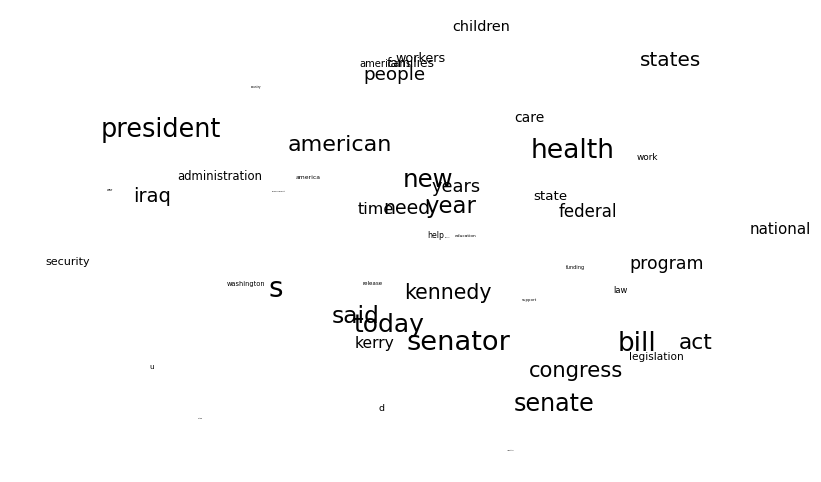

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents.

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [5]:
! pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=b535f5c48102935068c045cae85c9a279fd14b356eddd8c2e731c0f75d72b483
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing).

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [6]:
import fasttext

In [7]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "/content/drive/MyDrive/hw/fil9"

In [ ]:
model = fasttext.train_unsupervised(file_address, minCount=200, epoch=1)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

In [ ]:
model.save_model("fil9.bin")

In [ ]:
# when we want to use the model again
model = fasttext.load_model("fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

In [ ]:
# Add FastText here

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why?

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

Using word2vec TSNE and PCA

In [100]:
# takes 5 minutes
truth_df = pd.read_pickle("/content/drive/MyDrive/hw/adopt-proj/truth_df_vect_sents.pkl")
summed_truth = truth_df['normalized_sents'].sum()
truth_w2v = gensim.models.word2vec.Word2Vec(summed_truth, sg=0)

In [101]:
# save the word2vec
truth_w2v.save("truth_w2v")

In [102]:
numWords = 50
targetWords = truth_w2v.wv.index_to_key[:numWords]

# 50 rows
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(truth_w2v.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)


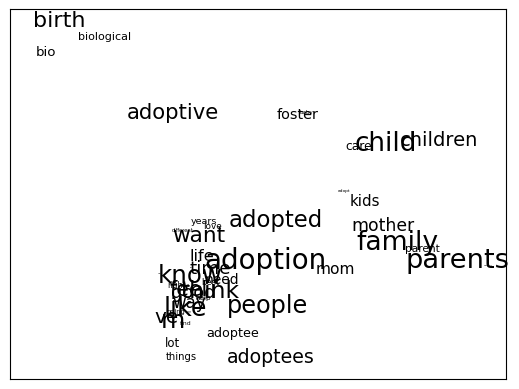

In [103]:
# PCA
pcaWords = sklearn.decomposition.PCA(n_components = 50,random_state=42).fit_transform(wordsSubMatrix)

plt.scatter(pcaWords[:, 0], pcaWords[:, 1], alpha=0)  # Adjust alpha as needed
for i, word in enumerate(targetWords):
    plt.annotate(word, (pcaWords[:, 0][i], pcaWords[:, 1][i]), size=20 * (numWords - i) / numWords)

plt.xticks(())
plt.yticks(())
plt.show()

Some of the relationships between words is much less clear. We still see that mom and mother are closely related. As are parents, family, and parent. Children and child are actually somewhat farther apart than I would expect. Biological, birth, and bio are all close together. In this context these words are used synonymously with one another so it makes sense. Adoptive is close to bio and the rest because these adjectives are both used to describe the same set of nouns, but give them entirely different meanings. The rest of the mess in the center is much less easy to interpret. Also some stop words are still within the text despite efforts to remove them.

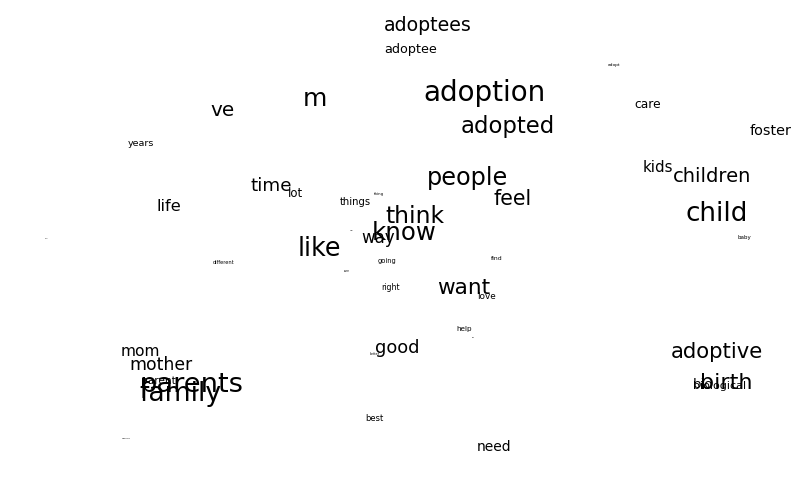

In [104]:
tsneWords = sklearn.manifold.TSNE(n_components = 2, random_state=42).fit_transform(wordsSubMatrix)

# lets plot the top 50 words
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)

plt.xticks(())
plt.yticks(())
plt.show()

We see that words like parent, parents, family, mom, nother are all close together. This makes sense as discussions surrounding these topics are all related. Often when adoptees talk about their family they particularly discuss their mothers. It is not surprising to see that father is also there (just much smaller). Kids, children ,child and baby are also close together. We see the clusters are more spread out so it is easier to read.  Therefore it seems that t-sne is a more robust technique than just PCA.

In [233]:
#senReleasesW2V.wv.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])
truth_w2v.wv.most_similar(positive=["bio", 'amom'], negative = ["adoptive"])

[('bmom', 0.7492926120758057),
 ('bm', 0.7040479183197021),
 ('biomom', 0.6841842532157898),
 ('bf', 0.6714481115341187),
 ('stepson', 0.6598187685012817),
 ('bfather', 0.6485056281089783),
 ('uncle', 0.6479417681694031),
 ('biodad', 0.6389748454093933),
 ('bdad', 0.638667106628418),
 ('aunt', 0.6332116723060608)]

We see that the model can understand the that amom + bio - adoptive equals bmom, bm, or biomom. These are all terms used to describe the birth mothers of adoptees. We also see bfather, biodad, and bdad make appearances which are also used in similar ways as bmom

In [149]:
truth_w2v.wv.most_similar('mother')

[('father', 0.783863365650177),
 ('parent(s', 0.7317707538604736),
 ('mom', 0.6680701971054077),
 ('mum', 0.606245756149292),
 ('fathers', 0.6008546352386475),
 ('parents', 0.5989863276481628),
 ('parent', 0.5979481339454651),
 ('giver', 0.5935288071632385),
 ('moms', 0.5709162950515747),
 ('mothers', 0.5684110522270203)]

We see that the most similar word vector to mother is father. We also see it is clsoe to parent, mom, mum, etc

In [152]:
truth_w2v.wv.most_similar('adoption')

[('adoptions', 0.6605902910232544),
 ('domestic', 0.5116255283355713),
 ('practices', 0.4998442828655243),
 ('ethics', 0.49852198362350464),
 ('ethical', 0.49600017070770264),
 ('semi', 0.49488863348960876),
 ('dia', 0.493638813495636),
 ('lifers', 0.4886603355407715),
 ('predatory', 0.4811616539955139),
 ('exploitive', 0.47018423676490784)]

The above produces some surprising results. Some of the most similar words to adoption include ethics, ethical, predatory, ane exploitive. I am unsure what dia and lifers mean in this context.

In [154]:
truth_w2v.wv.most_similar('transracial')

[('interracial', 0.8698821663856506),
 ('transnational', 0.7671091556549072),
 ('transcultural', 0.7610722780227661),
 ('centric', 0.7426438927650452),
 ('particularly', 0.6993312835693359),
 ('centering', 0.6918477416038513),
 ('trans', 0.6811349391937256),
 ('international', 0.6790251731872559),
 ('disclosures', 0.6759282946586609),
 ('inter', 0.6756508350372314)]

This model picks up on synonyms well. transracial in this context generally means the same thing as interracial, transnational, and transcultural.

In [188]:
truth_w2v.wv.most_similar('adoptee')

[('adoptees', 0.7331448197364807),
 ('tra', 0.62672358751297),
 ('birthparent', 0.5435163974761963),
 ('transracial', 0.5324499607086182),
 ('ap', 0.5196412205696106),
 ('transnational', 0.49463796615600586),
 ('voices', 0.47875678539276123),
 ('speaking', 0.4727034568786621),
 ('firsthand', 0.45314618945121765),
 ('tras', 0.45311254262924194)]

In [186]:
truth_w2v.wv.most_similar(positive=["korean", 'adoptee'])

[('tra', 0.8081364631652832),
 ('transracial', 0.6896395087242126),
 ('asian', 0.6775376200675964),
 ('trans', 0.671906054019928),
 ('native', 0.6717400550842285),
 ('american', 0.670586347579956),
 ('tras', 0.6629027724266052),
 ('russian', 0.6597408652305603),
 ('chinese', 0.6419920921325684),
 ('diaspora', 0.6398504376411438)]

We see that adding Korean to adoptee makes the tra vector closer in similarity than just adoptee alone.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [192]:
apsDF = pd.read_csv('/content/drive/MyDrive/hw/content-analysis-hw/data/APSabstracts1950s.csv', index_col = 0)

apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [193]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [194]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [195]:
from gensim.models.doc2vec import TaggedDocument

taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [196]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words.

In [197]:
apsD2V.docvecs[1952]

array([ 0.07489243,  2.186578  , -0.56416583,  0.41239923, -0.10154147,
        1.1798104 , -0.94080865,  0.04466488,  0.40496317, -0.5430078 ,
       -1.749479  , -1.5799739 ,  0.47348434, -0.01324146, -1.0385047 ,
        1.2291752 , -0.3107309 ,  0.62646735,  0.04860877, -0.8292934 ,
        2.0035903 ,  1.3971086 ,  0.26906234,  1.0019696 , -1.4491923 ,
       -0.4375143 ,  0.1461975 ,  0.09611239,  0.40247077,  1.0815092 ,
        0.8838329 , -0.7727587 , -0.74772584,  2.3719556 , -1.1486611 ,
       -1.1495502 ,  0.35744888, -0.9649702 , -0.29494342, -1.424428  ,
        1.0164223 , -1.5882492 , -1.3663061 ,  0.24821687, -1.1192733 ,
        0.25270912, -1.7487099 ,  0.08663142, -2.3769715 ,  0.4609284 ,
       -1.63268   ,  0.04361724,  0.7228351 , -0.65838265, -1.6484697 ,
       -1.6807206 ,  0.20152518,  0.1538997 , -0.41697404, -0.73916274,
       -1.7645881 , -0.8277614 ,  1.085411  , -0.16553803, -1.4257022 ,
       -0.7457362 ,  0.8903113 ,  0.13629071, -2.2070014 ,  0.89

The words can still be accessed in the same way:

In [198]:
apsD2V['atom']

array([-1.1215868 , -1.0516866 ,  1.1852763 , -1.3207175 ,  1.242641  ,
        0.15170312, -0.5379768 ,  0.89689034,  0.34776646,  0.6903166 ,
       -1.0955461 ,  0.5389658 , -0.23486206,  0.01822914, -0.1367922 ,
        2.063131  , -0.30779895,  1.8688622 ,  0.13244674, -1.7412298 ,
       -2.1475616 ,  1.3052893 , -0.00575868,  0.6392459 ,  0.5443224 ,
        0.27834547,  0.4555879 ,  0.45114335, -0.20063767,  1.0316973 ,
        0.43989277, -0.34586743, -0.04704897,  0.6141659 , -1.0537347 ,
       -0.7250107 ,  0.2878093 , -0.32550654,  0.6309646 ,  0.02725654,
        1.1929656 ,  0.19238079, -1.1071923 , -1.8485398 ,  1.4160572 ,
        0.35338804, -0.4140689 ,  0.27078858, -0.14954187,  1.3394003 ,
        0.6202496 ,  0.00272987,  1.0047673 , -0.3958988 ,  0.05599122,
        0.06883843,  0.5789875 , -0.9080454 ,  1.2518547 , -0.04459517,
       -0.73349124,  0.15561967,  0.752654  , -0.31851786, -1.1652997 ,
       -0.6746193 , -0.5464184 , -0.71473753,  0.18669511, -0.05

We can still use the ``most_similar`` command to perform simple semantic equations:

In [222]:
apsD2V.wv.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7579839825630188)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**!

In [200]:
apsD2V.wv.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('tisza', 0.7061747312545776)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra:

In [201]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.40268427]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [202]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.89.930', 0.428191602230072),
 ('10.1103/PhysRev.100.1037', 0.41776788234710693),
 ('10.1103/PhysRev.113.1545', 0.4006679356098175),
 ('10.1103/PhysRev.104.584', 0.3922360837459564),
 ('10.1103/PhysRev.89.472', 0.39042240381240845)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

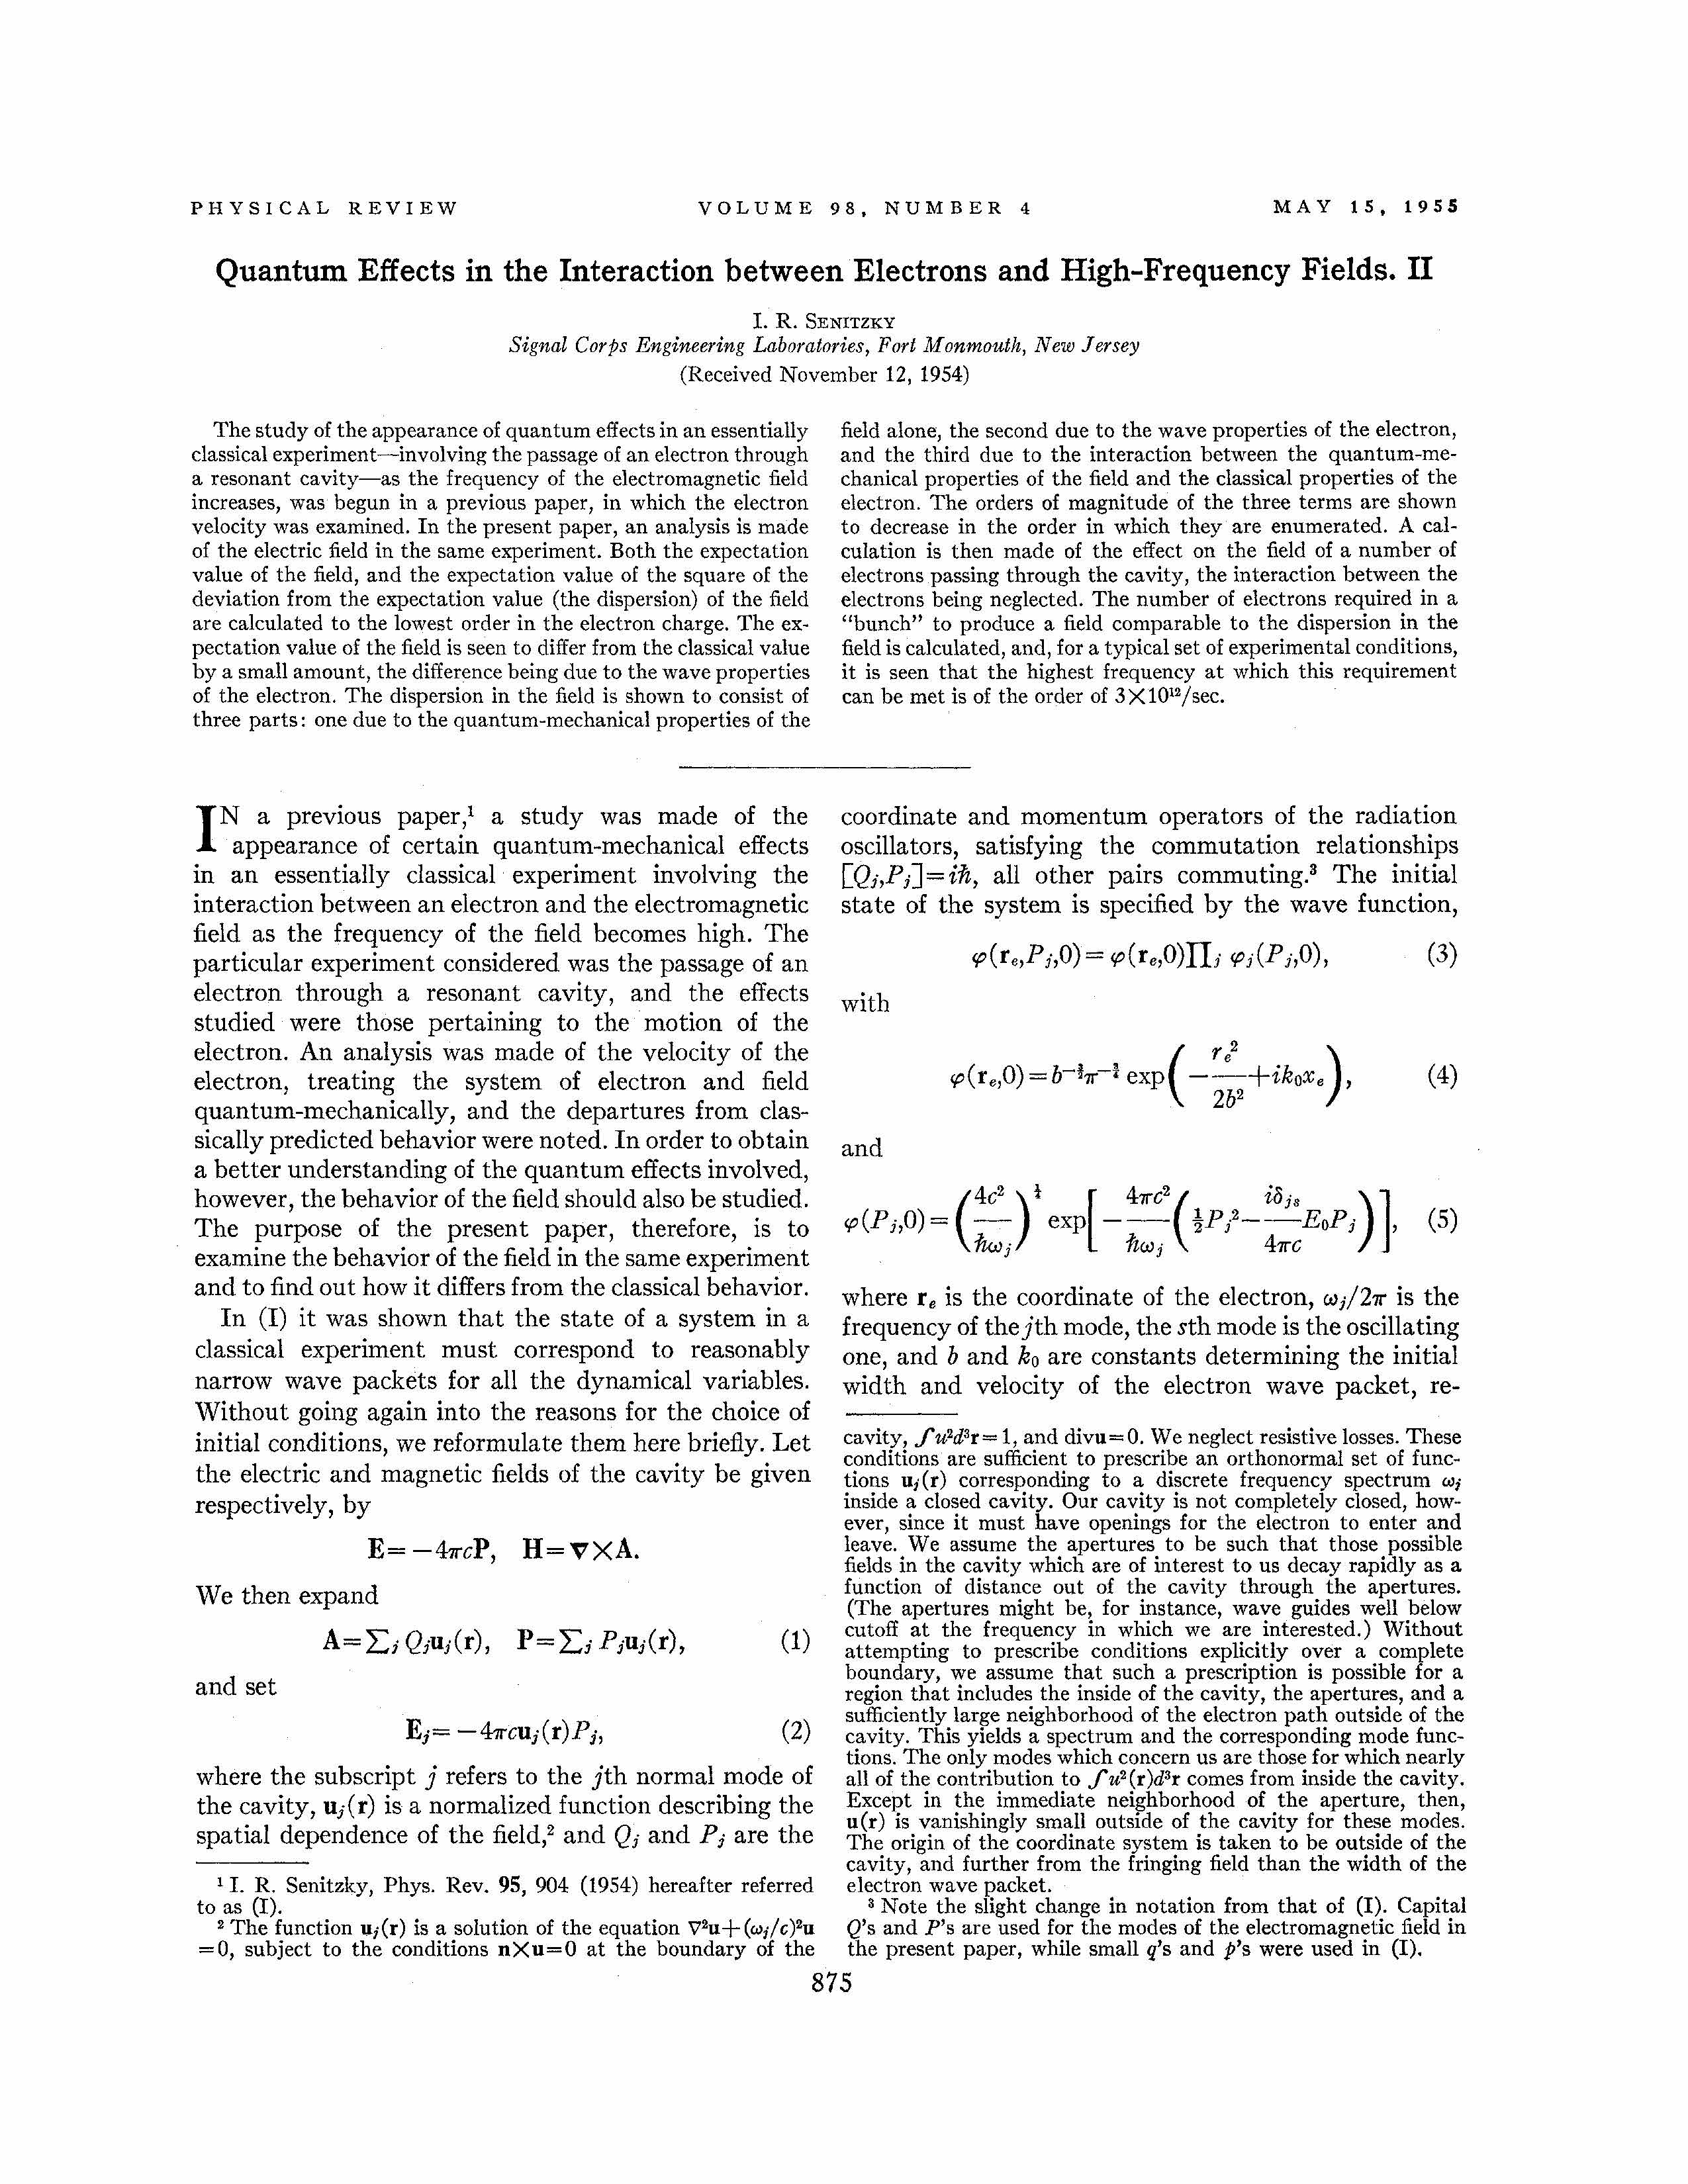

In [204]:
from IPython.display import Image
Image("/content/drive/MyDrive/hw/content-analysis-hw/data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [205]:
apsD2V.wv.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5)

[('volts', 0.62711101770401),
 ('attainable', 0.5907728672027588),
 ('radio', 0.5793935656547546),
 ('demagnetizing', 0.5607050061225891),
 ('varying', 0.5598020553588867)]

We can even look for documents most like a query composed of multiple words:

In [206]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.109.1263', 0.5241894125938416),
 ('10.1103/PhysRev.108.809', 0.5116395950317383),
 ('10.1103/PhysRev.99.786', 0.5045351386070251),
 ('10.1103/PhysRev.87.1032', 0.5035964846611023),
 ('10.1103/PhysRev.113.246', 0.494342565536499)]

Now let's plot some words and documents against one another with a heatmap:

In [208]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

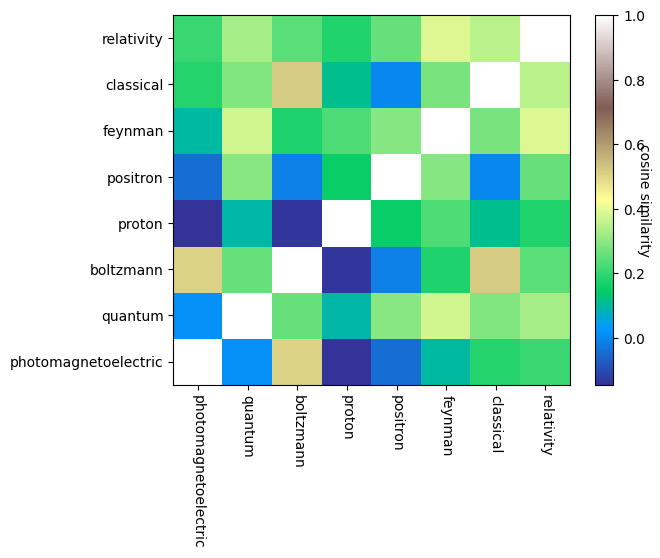

In [209]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [315]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

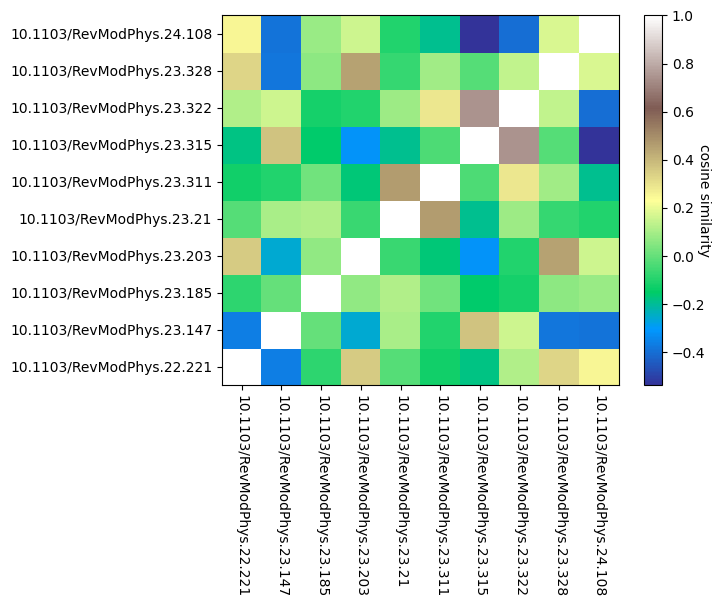

In [211]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [212]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

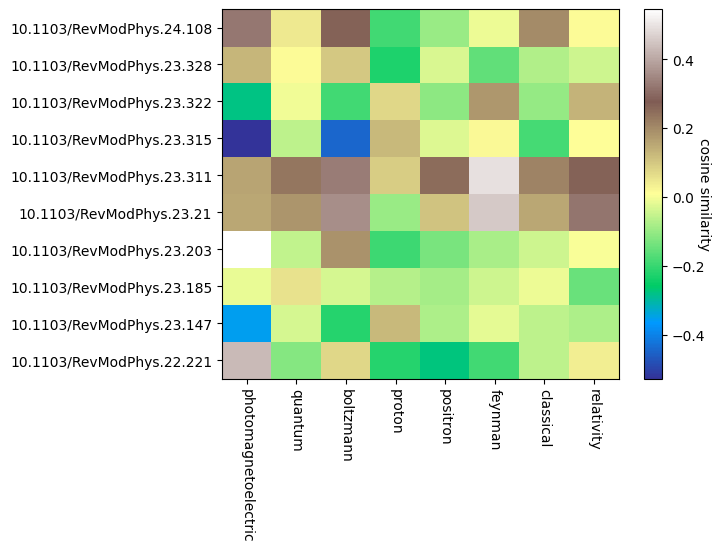

In [213]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [331]:
from gensim.models.doc2vec import TaggedDocument

keywords = ['trauma', 'silence', 'voice', 'hear', 'bad', 'negative',
            "positive", "good", "safe", "transracial", "domestic"]

taggedDocs = []
for index, row in truth_df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_tokens']]
    docKeywords.append(row['user'])
    docKeywords.append(row['is_adoptee'])
    docKeywords.append(row['cleaned_post_text'])
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_tokens'], tags = docKeywords))
truth_df['tagged_posts'] = taggedDocs

In [332]:
adopt_d2v = gensim.models.doc2vec.Doc2Vec(truth_df['tagged_posts'], vector_size = 100) #Limiting to 100 dimensions

In [323]:
adopt_d2v.wv.most_similar(positive=["amom", 'bio'], negative = ["adoptive"], topn = 10)

[('w', 0.5788666605949402),
 ('bmom', 0.5766274929046631),
 ('adad', 0.564215362071991),
 ('bdad', 0.5353955030441284),
 ('auntie', 0.5247416496276855),
 ('biofather', 0.5063962936401367),
 ('bf', 0.4996454119682312),
 ('biodad', 0.48639675974845886),
 ('biomom', 0.47917860746383667),
 ('alcoholic', 0.47643181681632996)]

We still see that amom - adoptive + bio results in bmom, but also bdad. It is less clear the linkage between the two than word2vec.

Let's move on to find document related similarities

In [310]:
adopt_d2v.docvecs.most_similar([ adopt_d2v['trauma'] ], topn=10)

[('Source for these studies   I have read many  all which find a loss associated  but none that show that it is  like a death  or what a parent is death even means to a just born infant   Generally  relinquishment is referred to as an adverse childhood experience in the research I am aware of  That  I believe  is a very valid statement  ACEs can be traumatic  or they can add up to be traumatic  but I would not consider them necessarily traumatic individually ',
  0.5392691493034363),
 ('I believe it is because many people are terrified to think anything negative  bad  or  traumatizing  could be the direct result from the adoption experience itself   I could say that I feel X as a result of my adoption  but I ve had so many people ask me  Are you  sure  it was  precisely  due to your adoption that you feel X   Or  I was not adopted but I dealt with X and I learned to adjust handle recover   what makes you so sure  adoption  caused X  ',
  0.49690765142440796),
 ('I would focus a lot mor

In [311]:
adopt_d2v.docvecs.most_similar([ adopt_d2v['domestic'] ], topn=10)


[('I am talking about the subset of children who are adopted  Whether international  infant adoption  foster care or whatever',
  0.5682487487792969),
 ('https   www ncbi nlm nih gov pmc articles PMC          https   www ncbi nlm nih gov pmc articles PMC          i did not find a specific study involving foster vs infant adoptees directly  but we can see here that infant adoptees only have a slightly higher mental health issues as compared to the general population vs foster kids have a strikingly higher mental health problems than the general population    i mean sure  attachment issues can happen even with bio kids  but it is about likelihood ',
  0.5659239888191223),
 ('I was also a non infant adoption  I for sure have some issues related  but older kids need those stable environments of healthy and supportive adoptive or foster families',
  0.5622365474700928),
 ('msg me   we have been through   internationals  not infant  and know a bit about working through foster adopt and vario

In [312]:
adopt_d2v.docvecs.most_similar([ adopt_d2v['transracial'] ], topn=10)

[('A lot of what adoptees hear and internalize around adoption is that their  real  parents are their adoptive parents  and they should feel grateful for their adoption and should not have any curiosity about or need to find their biological parents   Sometimes this message comes from their adoptive parents   I think  hope  it is less common these days than it was     years ago  but it still happens   And sometimes there is a reason for that that is not the APs  fault   When closed adoptions were still the default  they were told by agencies that adopting was no different than having a biological child   The reality is that of course it is   We are more prone to mental disorders  suicide  criminal behavior   Most of us have a pre AP history and natural curiosity about our biological families that can be difficult for non adoptees  and even some other adoptees  to understand   And when reality turns out to be different from what the APs were told  they can feel threatened by the search 

Some of these keywords produce documents that are closer together than others. Domestic and trauma do a pretty good job at linking documents that seem thematically similar to one another. Interestingly, a lot of the transracial documents were related to suicide.

In [334]:
adopt_d2v.wv.most_similar( [ adopt_d2v.docvecs["trauma"] ], topn=5)

[('denier', 0.5864130854606628),
 ('intergenerational', 0.5722706317901611),
 ('preverbal', 0.5000314712524414),
 ('generational', 0.494817316532135),
 ('relive', 0.46857184171676636)]

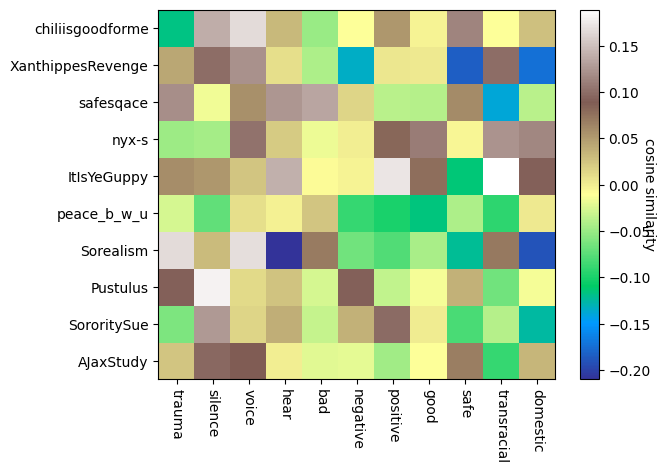

In [350]:
# user vs keywords
targetDocs = truth_df['user'][:1000:100]
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = adopt_d2v.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, adopt_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)


We see that for the first few users, these labels do not well apply to the documents. The highest on the scale is -.2. It reveals that perhaps a more careful seletion of keywords is necessary. Furthermore

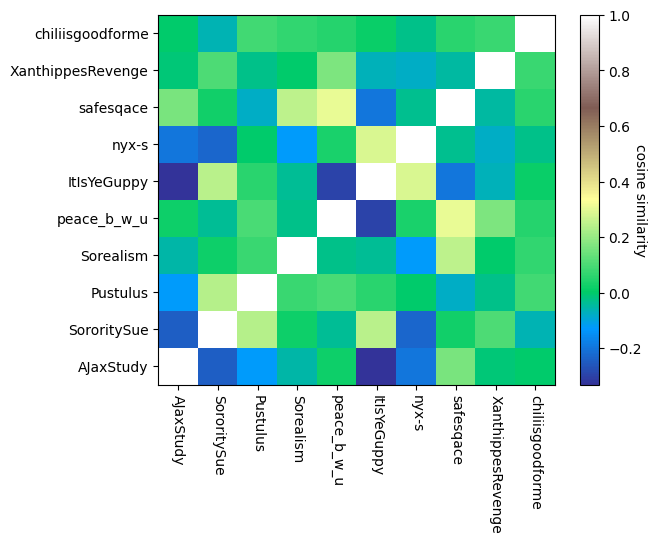

In [352]:
targetDocs = truth_df['user'][0:1000:100]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = adopt_d2v.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, adopt_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)


fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We see that most posts are not very similar to one another (low consine similarity). In fact many of these users seem to be almost orthogonal to one another

We can see thusly that the documents in this corpus are very loosely organized. Many of the users are distinct from one another (orthogonal).

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles.

In [353]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/hw/content-analysis-hw/data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [364]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix


In [365]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

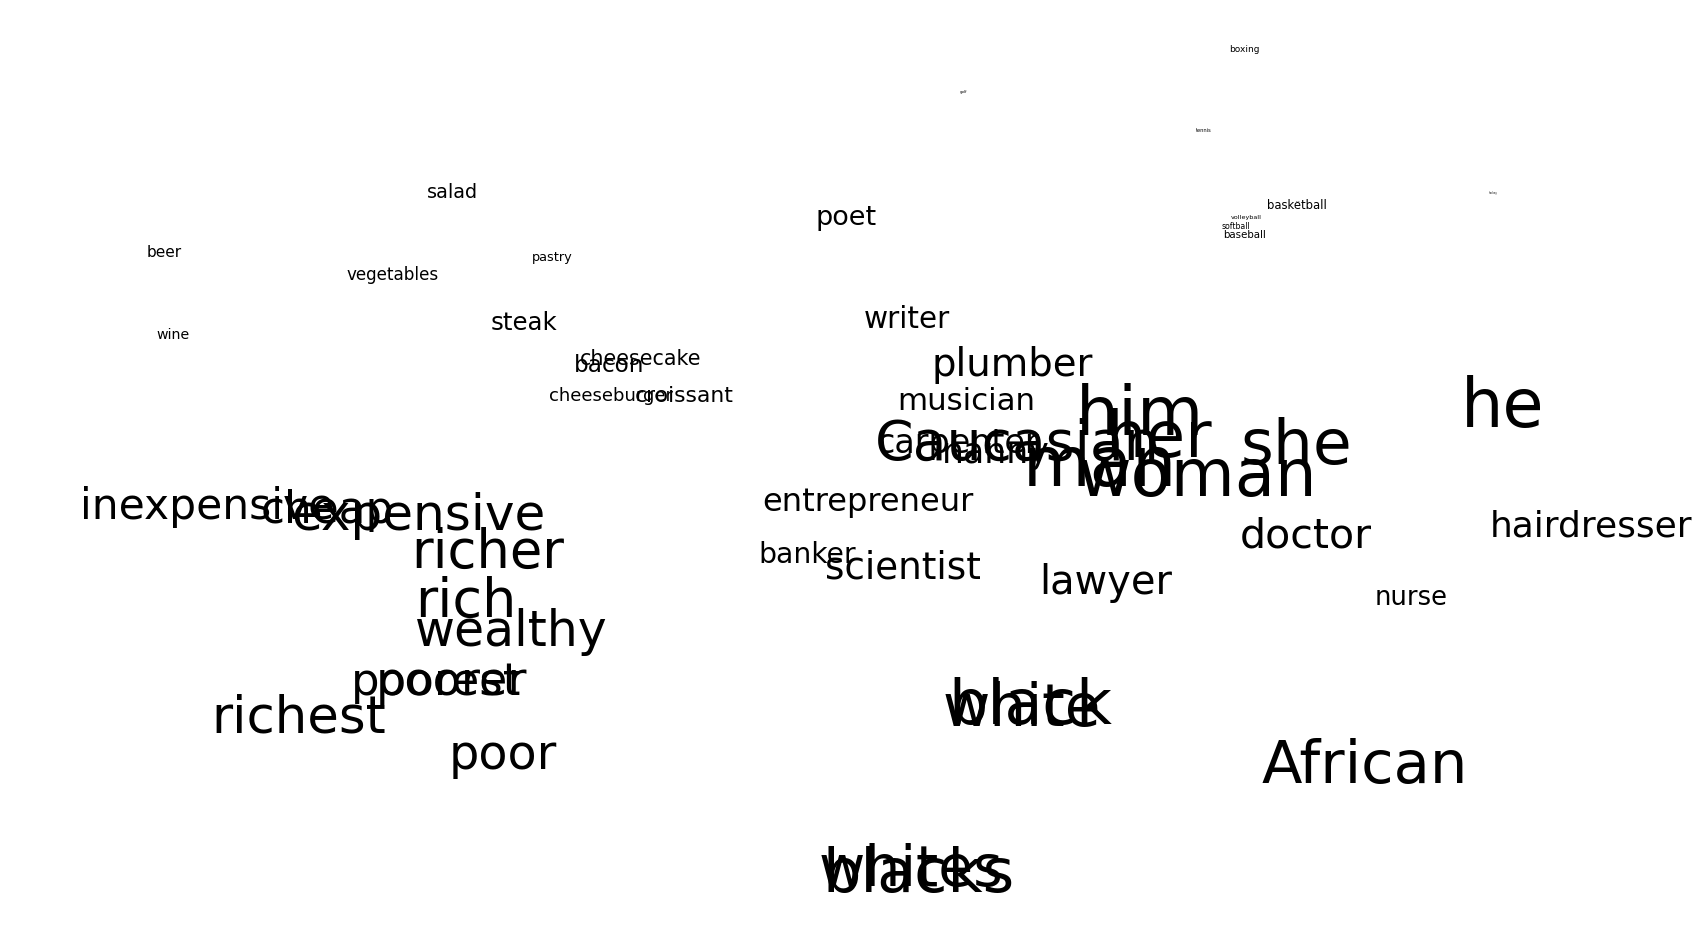

In [366]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions.

In [367]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [368]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [369]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [370]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [371]:
OCCdf = makeDF(nytimes_model, Occupations)
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [372]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

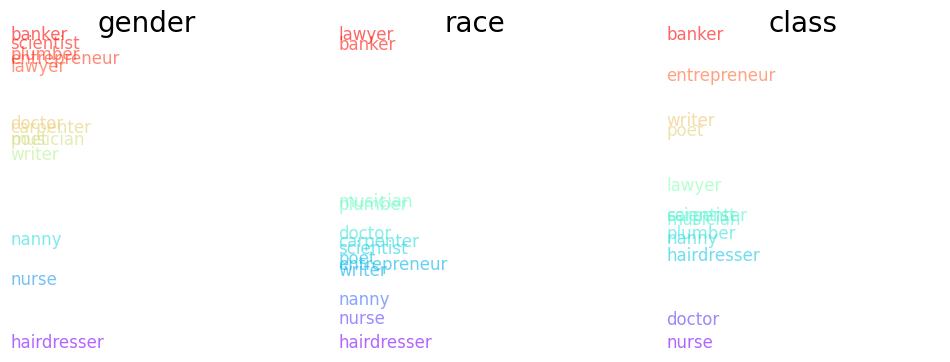

In [374]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

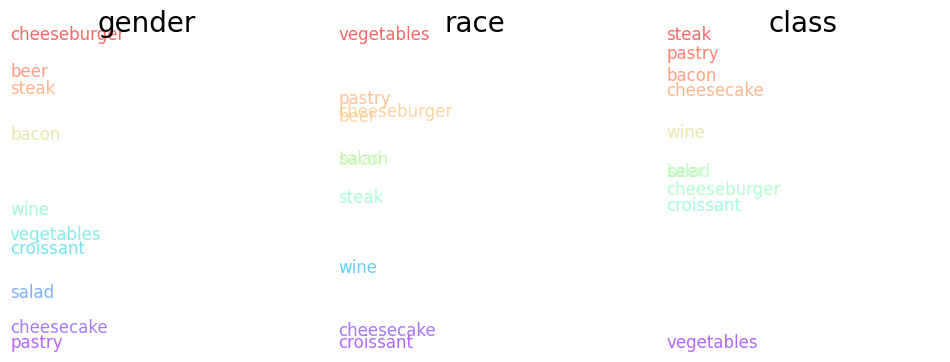

In [375]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

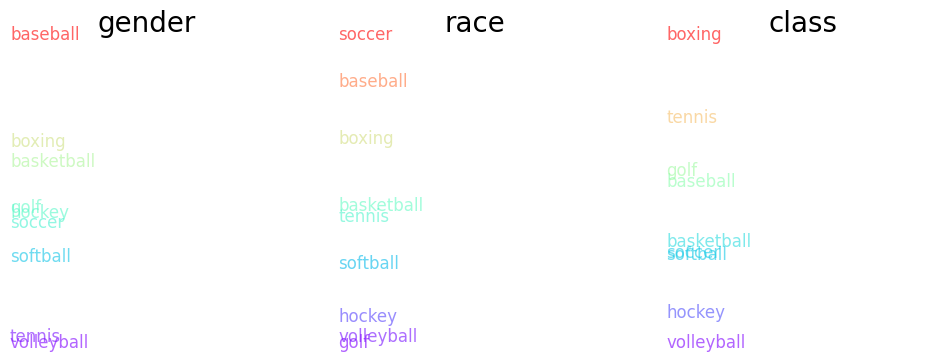

In [376]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why?

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [390]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

# fixed using Chat GPT
def dimension(model, positives, negatives):
    positive_vectors = [normalize(model.wv[word]) for word in positives if word in model.wv]
    negative_vectors = [normalize(model.wv[word]) for word in negatives if word in model.wv]

    diff = sum(positive_vectors) - sum(negative_vectors)
    return diff


def makeDF(model, word_list):
    p = []
    s = []
    st = []
    for word in word_list:
        p.append(sklearn.metrics.pairwise.cosine_similarity(model.wv[word].reshape(1,-1), parent.reshape(1,-1))[0][0])
        s.append(sklearn.metrics.pairwise.cosine_similarity(model.wv[word].reshape(1,-1), source.reshape(1,-1))[0][0])
        st.append(sklearn.metrics.pairwise.cosine_similarity(model.wv[word].reshape(1,-1), status.reshape(1,-1))[0][0])
    df = pd.DataFrame({'parent': p, 'source': s, 'status': st}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [424]:
parent = dimension(truth_w2v, ['mom','mother','amom', "bmom"], ['dad', 'father', 'bdad', "adad"])
source = dimension(truth_w2v, ['domestic','white','black', "states", "native", "uk", "usa", "dia"], ['interracial', "tra", "transracial", 'korean', 'chinese', "asian"])
status = dimension(truth_w2v, ["bio","biological", "bmom", "birth", "bdad", "birthmom", "biomom", "search"], ['adoptive', 'adopted', 'amom', 'adad', 'afamily', "adopt"])

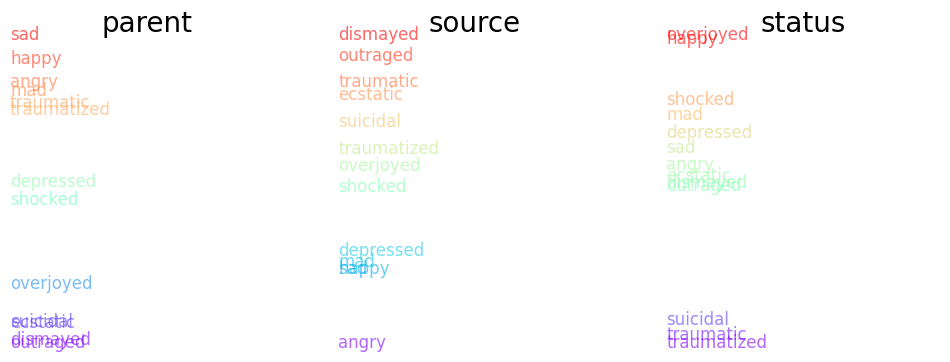

In [425]:
emotions = ["happy", "sad", "angry", "mad", "outraged", "dismayed", "traumatic",
            "shocked", "depressed", "ecstatic", "overjoyed", "traumatized", "suicidal"]
emot_df = makeDF(truth_w2v, emotions)

fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, emot_df, 'parent')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, emot_df, 'source')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, emot_df, 'status')
plt.show()

We see that emotions related to discussing mothers include sad, happy, angry, and mad. We see that more enhanced versions of the same words are more related to fathers. We further see that posts discussing transracial adoption are definitely related to the word angry. Whereas doemstic adoptions are more related to most of the others. As for status, we see that posts talking about adoptees talking about their adoptive families generally have more negatives than posts who discuss their birth parents or being a birthmom.  It seems as though parent and status seem to do well enough for discerning the most variation in my projection of words. Particularly for status, posts that talk about birhtmoms are generally in a context of reuniting or something whereas the discussion about adoptive parents may be more related to venting.

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf).

In [427]:
import copy

In [428]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = calc_syn0norm(in_base_embed)
    # other_vecs = calc_syn0norm(in_other_embed)
    base_vecs= [in_base_embed.wv.get_vector(w,norm=True) for w in set(in_base_embed.wv.index_to_key)]
    other_vecs= [in_other_embed.wv.get_vector(w,norm=True) for w in set(in_other_embed.wv.index_to_key)]

    # just a matrix dot product with numpy
    m = np.array(other_vecs).T.dot(np.array(base_vecs))
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors =(np.array(other_vecs)).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count")  + m2.wv.get_vecattr(w, "count") ,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        new_arr = [m.wv.get_vector(w,norm=True) for w in common_vocab]

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i={}
        for new_index,word in enumerate(common_vocab):
            new_vocab.append(word)
            k2i[word]=new_index
        m.wv.index_to_key=new_vocab
        m.wv.key_to_index=k2i
        m.wv.vectors=np.array(new_arr)

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [429]:
apsDF = pd.read_csv("/content/drive/MyDrive/hw/content-analysis-hw/data/APSabstracts1950s.csv", index_col=0)

Prepare for wor2vec:

In [430]:
apsDF['tokenized_sents'] = apsDF['abstract'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
apsDF['normalized_sents'] = apsDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [460]:
apsDF.head()

,copyrightYear,doi,abstract,tokenized_sents,normalized_sents
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[[A, summarizing, account, is, given, of, the,...","[[summarizing, account, give, research, barium..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[[New, tables, of, coulomb, functions, are, pr...","[[new, table, coulomb, function, present, intr..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[[Ionization, by, electron, impact, in, diatom...","[[ionization, electron, impact, diatomic, gas,..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[[It, is, shown, that, the, conductivity, in, ...","[[show, conductivity, ohmic, cuprous, oxide, l..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[[The, factorization, method, is, an, operatio...","[[factorization, method, operational, procedur..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [454]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned


In [455]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [528]:
rawEmbeddings, comparedEmbeddings = compareModels(apsDF, 'copyrightYear')

In [434]:
rawEmbeddings.keys()

dict_keys([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [450]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                                                                             np.expand_dims(embed.wv[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

Lets look at a couple words:

In [474]:
targetWord = 'radioactive'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

radioactive


KeyError: "Key 'radioactive' not present"

area


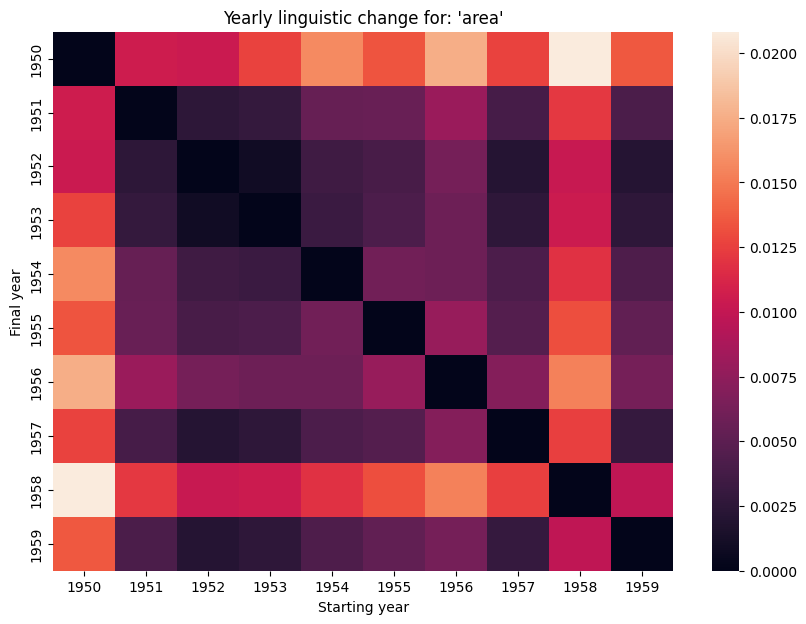

In [461]:
targetWord = 'area'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [462]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0].wv[word], axis = 0), np.expand_dims(embed.wv[word], axis = 0))[0,0])
        except:
            pass
    return np.mean(dists)

def findMostDivergent(embeddingsDict):
    original_words = comparedEmbeddings[1950][0].wv.index_to_key
    for embeds in embeddingsDict.values():
        for embed in embeds:
            original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)


In [464]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 843 words to compare


The most divergent words are:

In [465]:
wordDivergences[:20]

[('magnetization', 0.9999998907964167),
 ('lens', 0.9999996198305858),
 ('preliminary', 0.9999995881972692),
 ('partial', 0.9999992514019705),
 ('year', 0.4057585261771777),
 ('uniform', 0.4030447146763656),
 ('dirac', 0.3163778571362215),
 ('extrapolate', 0.31607200188981277),
 ('saturation', 0.312376303545345),
 ('thickness', 0.3099215094425006),
 ('vary', 0.30631639147789685),
 ('boltzmann', 0.30505540223578864),
 ('respectively', 0.30482824386632357),
 ('bind', 0.30459051878734583),
 ('ionization', 0.3044479895282322),
 ('rapidly', 0.3040158588615462),
 ('briefly', 0.3037458851546148),
 ('upper', 0.30374443053525796),
 ('dependent', 0.3036154618014052),
 ('derive', 0.3030625616347429)]

And the least:

In [466]:
wordDivergences[-20:]

[('canonical', 0.003277146816253662),
 ('dependence', 0.0032655119895935057),
 ('curie', 0.003265327215194702),
 ('period', 0.0032468974590301515),
 ('separation', 0.0031890034675598144),
 ('normal', 0.0031369686126708984),
 ('b10', 0.0030764281749725343),
 ('thermal', 0.0030705571174621583),
 ('basis', 0.003043562173843384),
 ('vibration', 0.002996218204498291),
 ('axis', 0.002935105562210083),
 ('h2', 0.0028324902057647707),
 ('penetration', 0.0028130948543548585),
 ('solid', 0.0027530252933502196),
 ('anomaly', 0.002743697166442871),
 ('note', 0.002743029594421387),
 ('cm2', 0.002719372510910034),
 ('show', 0.002693319320678711),
 ('electronic', 0.00247153639793396),
 ('kev', 0.002337336540222168)]

complete


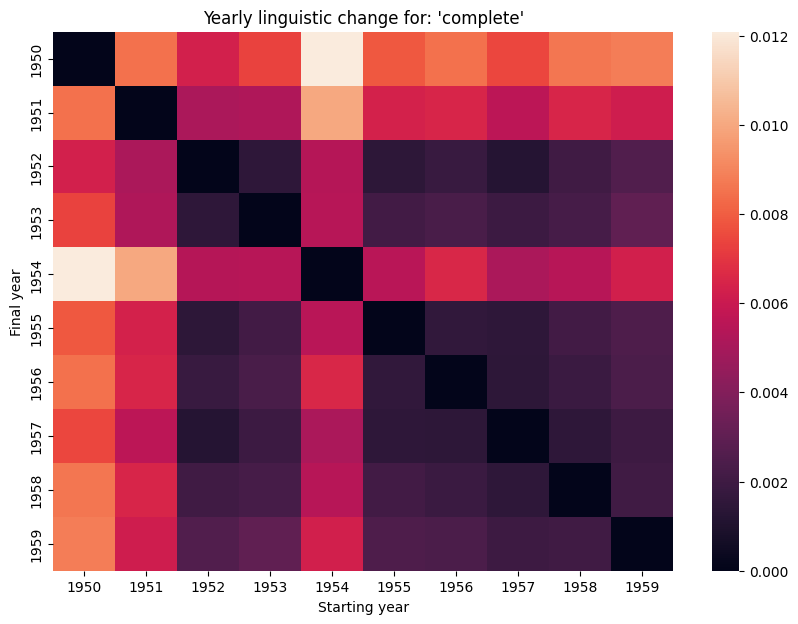

In [467]:
targetWord = wordDivergences[-200][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

kev


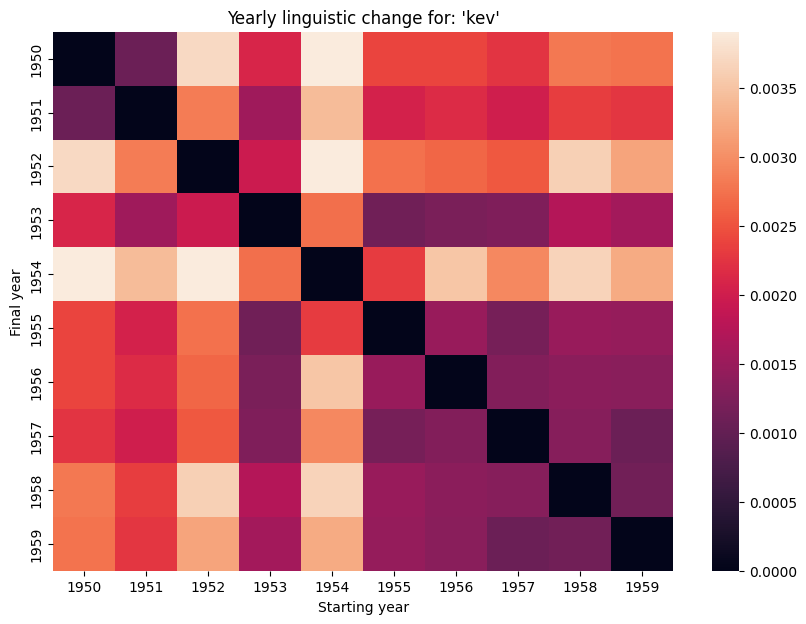

In [468]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
##We only use a small data here so some of the results may not make sense. You can try the algorithm on your own data!

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [ ]:
corpora_address = "COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [ ]:
coha_df = pd.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)

    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4

    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space?

In [520]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned


def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw


def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                                                                             np.expand_dims(embed.wv[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)


def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0].wv[word], axis = 0), np.expand_dims(embed.wv[word], axis = 0))[0,0])
        except:
            pass
    return np.mean(dists)

def findMostDivergent(embeddingsDict):
    original_words = comparedEmbeddings[2011][0].wv.index_to_key
    for embeds in embeddingsDict.values():
        for embed in embeds:
            original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)



def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings


In [501]:
truth_df['post_date'] = pd.to_datetime(truth_df['post_date'])
truth_df['year'] = truth_df['post_date'].dt.year


<ipython-input-501-6438b16edc57>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  truth_df['year_month'] = truth_df['post_date'].dt.to_period('M')


In [530]:
rawEmbeddings, comparedEmbeddings = compareModels(truth_df, 'year')

In [531]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 136 words to compare


In [524]:
wordDivergences[:20]

[('possibly', 1.0),
 ('country', 1.0),
 ('incredibly', 1.0),
 ('extremely', 1.0),
 ('looking', 1.0),
 ('new', 1.0),
 ('adopted', 1.0),
 ('free', 1.0),
 ('care', 1.0),
 ('lot', 1.0),
 ('great', 1.0),
 ('long', 1.0),
 ('help', 1.0),
 ('foster', 1.0),
 ('hope', 1.0),
 ('homes', 1.0),
 ('adoptees', 1.0),
 ('korean', 1.0),
 ('children', 1.0),
 ('mothers', 1.0)]

In [525]:
wordDivergences[-20:]

[('find', 1.0),
 ('daughter', 1.0),
 ('adoption', 1.0),
 ('asking', 1.0),
 ('continue', 1.0),
 ('time', 1.0),
 ('order', 1.0),
 ('families', 1.0),
 ('social', 1.0),
 ('read', 1.0),
 ('luck', 1.0),
 ('thanks', 1.0),
 ('got', 1.0),
 ('bit', 1.0),
 ('domestic', 1.0),
 ('understand', 1.0),
 ('felt', 1.0),
 ('change', 1.0),
 ('etc', 1.0),
 ('black', 1.0)]

adoption


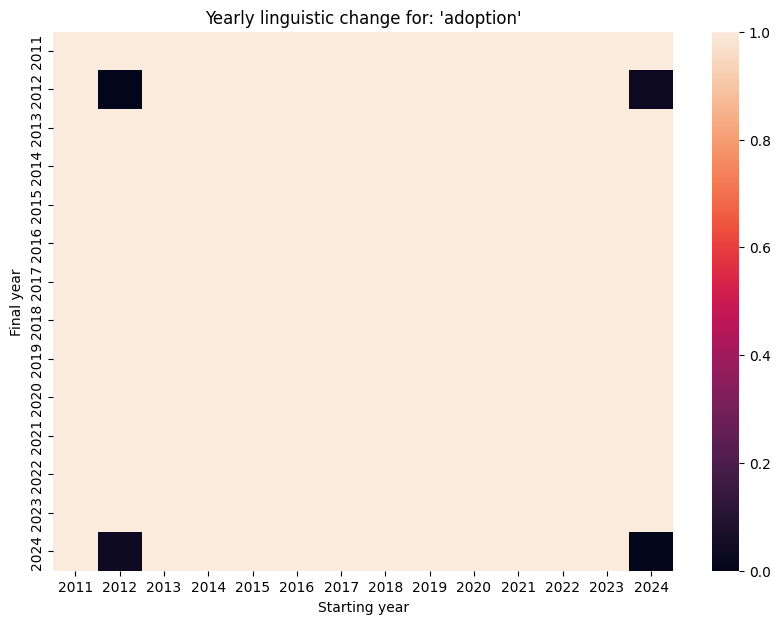

In [526]:
targetWord = 'adoption'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

change


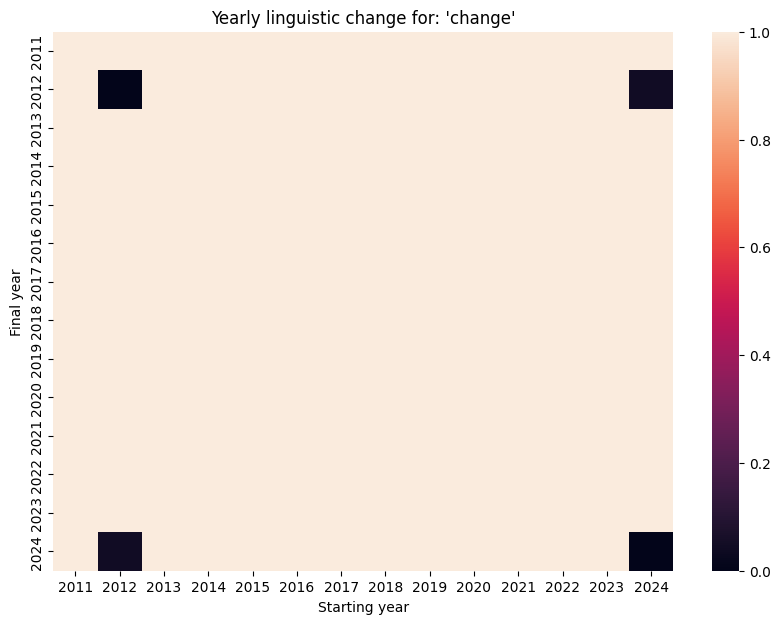

In [532]:
targetWord = 'change'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

I do not know what went wrong. All the divergences have turned to 1. Divergence appears to be 0 for the word adoptee adoption at for 2012 and 2024. The pattern persists for most words. I do not know what this means. However, I did not intend to utilize word use over time so this is not detrimental.

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
from gensim.test.utils import datapath
import re
import string, re
import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics.




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)

##create the saving folder if you need!!

def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'):
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms.
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document).



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
##make sure to create a saving path first

dictionary, alpha = do_aksvd(w2v, 150, 5, save=True)

In [ ]:
topic_diversity(w2v, dictionary, top_n=25)

In [ ]:
reconst_qual(w2v, dictionary, alpha)


In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

In [ ]:
#useful relevant code:
w2v.wv.index_to_key[3452]

In [ ]:
w2v.wv.most_similar('divorced', topn=15)

In [ ]:
np.where(alpha[w2v.wv.key_to_index['divorced']] != 0) #get index where the loading of a word onto discourse atoms is not 0